In [19]:
import tensorflow as tf
import tensorflow.keras as kr
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

physical_device = tf.config.experimental.list_physical_devices("GPU")
print(physical_device)

# 限制显存使用
tf.config.experimental.set_memory_growth(physical_device[0], True)

# load data set, need mnist.npz in current work folder
with np.load("resources/mnist.npz", allow_pickle=True) as f:
    x_train, y_train = f["x_train"], f["y_train"]
    x_test, y_test = f["x_test"], f["y_test"]

print(x_train.shape, x_test.shape)

# 数据重塑至四维 b w h c
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# 数据转换为float32
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

# 数据集归一到[-1,1]
x_train = (x_train - 127.5) / 127.5
x_test = (x_test - 127.5) / 127.5

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
(60000, 28, 28) (10000, 28, 28)


In [6]:
# Prepare for datasets
BATCH_SIZE = 64

def gen_datasets():
    global datasets, train_round
    datasets = (
        tf.data.Dataset.from_tensor_slices(x_train)
        .shuffle(x_train.shape[0])
        .batch(BATCH_SIZE)
    )
    train_round = tf.math.ceil(x_train.shape[0] / BATCH_SIZE)
    train_round = tf.cast(train_round, tf.int32)

In [8]:
def generator_model(noise_dim):
    model = tf.keras.Sequential()

    # When a popular kwarg `input_shape` is passed, then keras will create
    # an input layer to insert before the current layer. This can be treated
    # equivalent to explicitly defining an `InputLayer`.

    model.add(tf.keras.Input(shape=(noise_dim,)))

    model.add(tf.keras.layers.Dense(256, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Dense(512, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Dense(28 * 28, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('tanh')) #!!! 值域是[-1,1]

    model.add(tf.keras.layers.Reshape((28, 28, 1)))
    
    return model


def discrimmer_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(512, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Dense(256, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Dense(1))

    return model


pic_nums = 16
noise_dim = 100
seed = tf.random.normal((pic_nums,noise_dim))

print(seed.shape)

generator = generator_model(noise_dim)
discrimmer = discrimmer_model()

(16, 100)


In [9]:
# cross entropy loss 二分类的交叉熵损失 没有经过概率化输出
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 优化器
discrimmer_optimzer = tf.keras.optimizers.legacy.Adam(1e-4)
generator_optimzer = tf.keras.optimizers.legacy.Adam(1e-4)

In [15]:
import os
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimzer,
                                 discriminator_optimizer=discrimmer_optimzer,
                                 generator=generator,
                                 discriminator=discrimmer)

In [23]:
# real -> 1 fake -> 0
# 尝试最大化损失
def discrimmer_loss(real_out, fake_out):
    image_real_loss = cross_entropy(0.9 * tf.ones_like(real_out), real_out)
    image_fake_loss = cross_entropy(tf.zeros_like(fake_out), fake_out)
    return image_real_loss + image_fake_loss


# 尝试最小化损失
def generator_loss(fake_out):
    return cross_entropy(0.9 * tf.ones_like(fake_out), fake_out)


# 输出图像
def output_image(seed):
    gen_images = generator.call(inputs=seed, training=False)
    fake_out = discrimmer.call(inputs=gen_images, training=True)
    fake_loss = generator_loss(fake_out)
    gen_images = gen_images.numpy()
    gen_images = gen_images.reshape(gen_images.shape[0], 28, 28)

    plt.figure(figsize=(16, 1))
    for i in range(seed.shape[0]):
        plt.subplot(1, seed.shape[0], i + 1)
        plt.axis("off")
        plt.imshow(gen_images[i], cmap="binary")
    plt.show()

    return fake_loss


@tf.function
def train_steps(real_images):
    # Make some noise images
    noise = tf.random.normal((BATCH_SIZE, noise_dim))
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_images = generator.call(inputs=noise, training=True)

        real_out = discrimmer.call(inputs=real_images, training=True)
        fake_out = discrimmer.call(inputs=gen_images, training=True)

        disc_loss = discrimmer_loss(real_out, fake_out)
        gen_loss = generator_loss(fake_out)

    gen_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discrimmer.trainable_variables)

    # Apply gradient to variables
    generator_optimzer.apply_gradients(zip(gen_gradient, generator.trainable_variables))
    discrimmer_optimzer.apply_gradients(
        zip(disc_gradient, discrimmer.trainable_variables)
    )
    return [disc_loss, gen_loss]


gen_loss, disc_loss, seed_fake_loss = 0.0, 0.0, 0.0
LOSS_FILTER_FATCOR = 0.8


def train(epoches):
    for e in range(epoches):
        print("epoch: {}/{}".format(e + 1, epoches))
        i = 0
        round_gen_loss, round_disc_loss = 0.0, 0.0
        for image in datasets:
            i += 1
            losses = train_steps(image)
            round_gen_loss += losses[0]
            round_disc_loss += losses[1]
            if i % 20 == 0:
                print("{}/{}".format(i, train_round), end=" ")

        if (e + 1) % 40 == 0:  # 保存检查点
            checkpoint.save(file_prefix=checkpoint_prefix)  # 保存检查点

        print(end="\n")

        global gen_loss, disc_loss, seed_fake_loss
        train_round_fl = tf.cast(train_round, tf.float32)
        gen_loss = (
            LOSS_FILTER_FATCOR * gen_loss
            + (1.0 - LOSS_FILTER_FATCOR) * round_gen_loss / train_round_fl
        )
        disc_loss = (
            LOSS_FILTER_FATCOR * disc_loss
            + (1.0 - LOSS_FILTER_FATCOR) * round_disc_loss / train_round_fl
        )
        seed_fake_loss = LOSS_FILTER_FATCOR * seed_fake_loss + (
            1.0 - LOSS_FILTER_FATCOR
        ) * output_image(seed)
        print(
            "gen_loss:{:.4f}, disc_loss:{:.4f}, total_loss:{:.4f} seed_gen_loss:{:.4f}".format(
                gen_loss, disc_loss, gen_loss + disc_loss, seed_fake_loss
            )
        )

In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

epoch: 1/100
20/938 40/938 60/938 80/938 100/938 120/938 140/938 160/938 180/938 200/938 220/938 240/938 260/938 280/938 300/938 320/938 340/938 360/938 380/938 400/938 420/938 440/938 460/938 480/938 500/938 520/938 540/938 560/938 580/938 600/938 620/938 640/938 660/938 680/938 700/938 720/938 740/938 760/938 780/938 800/938 820/938 840/938 860/938 880/938 900/938 920/938 


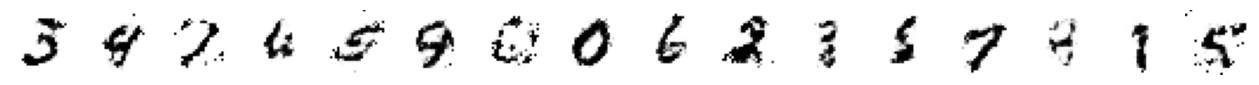

gen_loss:0.5651, disc_loss:0.8763, total_loss:1.4415 seed_gen_loss:1.0332
epoch: 2/100
20/938 40/938 60/938 80/938 100/938 120/938 140/938 160/938 180/938 200/938 220/938 240/938 260/938 280/938 300/938 320/938 340/938 360/938 380/938 400/938 420/938 440/938 460/938 480/938 500/938 520/938 540/938 560/938 

KeyboardInterrupt: 

In [26]:
gen_datasets()
train(100)

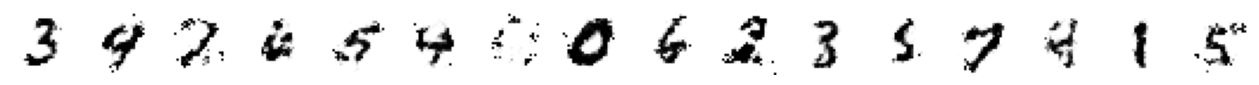

<tf.Tensor: shape=(), dtype=float32, numpy=1.3203292>

In [21]:
seed = tf.random.normal((pic_nums,noise_dim))
output_image(seed)